In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ANEMO import read_edf
from ANEMO import ANEMO

In [2]:
def regress(ax, x, y, t_label=20, color='r') :
    from scipy import stats
    x1, x2, y1, y2 = min(x), max(x), min(y), max(y)
    
    slope, intercept, r_, p_value, std_err = stats.linregress(x, y)
    x_test = np.linspace(x1, x2, 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=color, linewidth=2)
    ax.text(x2-(x2-x1)/10,y1+(y2-y1)/10, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    return ax

In [3]:
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [4]:
def comparaison(Title, file_X, file_Y,  xname, yname) :
    list_p = ['start_anti', 'v_anti', 'latence', 'maxi']
    fig, axs = plt.subplots(1, len(list_p), figsize=(7*len(list_p), (7/1.6180)))
    fig.suptitle(Title, fontsize=20)
    
    list_g = ['redchi', 'chisqr', 'bic', 'aic'] # 'nfev',
    fig1, axs1 = plt.subplots(1, len(list_g), figsize=(7*len(list_g), (7/1.6180)))
    fig1.suptitle(Title, fontsize=20)
    
    X_p, Y_p = {}, {}
    X_g, Y_g = {}, {}
    for p in list_p : X_p[p], Y_p[p] = [], []  
    for g in list_g : X_g[g], Y_g[g] = [], []

    for s in range(len(sujet)) :
        
        with open('parametre/param_Fit_%s_%s.pkl'%(sujet[s], file_X), 'rb') as fichier :
            p_x = pickle.load(fichier, encoding='latin1')
        with open('parametre/param_Fit_%s_%s.pkl'%(sujet[s], file_Y), 'rb') as fichier :
            p_y = pickle.load(fichier, encoding='latin1')

        with open('parametre/goodness_of_fit_%s_%s.pkl'%(sujet[s], file_X), 'rb') as fichier :
            g_x = pickle.load(fichier, encoding='latin1')
        with open('parametre/goodness_of_fit_%s_%s.pkl'%(sujet[s], file_Y), 'rb') as fichier :
            g_y = pickle.load(fichier, encoding='latin1')

        #-------------------------------------------------------------------------
        for i, p in enumerate(list_p) :
            for block in range(3) :                
                if p == 'v_anti' :
                    X_p[p].extend(np.array(p_x[p][block])*((np.array(p_x['latence'][block])-np.array(p_x['start_anti'][block]))/1000))
                    Y_p[p].extend(np.array(p_y[p][block])*((np.array(p_y['latence'][block])-np.array(p_y['start_anti'][block]))/1000))
                
                elif p == 'start_anti' :
                    sa_x, sa_y = [], []
                    for t in range(len(p_x['start_anti'][block])) :
                        if (abs(p_x['v_anti'][block][t]) and abs(p_y['v_anti'][block][t])) > 10 :
                            sa_x.append(p_x['start_anti'][block][t]) ; sa_y.append(p_y['start_anti'][block][t])
                    X_p[p].extend(sa_x) ; Y_p[p].extend(sa_y)
                else :
                    X_p[p].extend(p_x[p][block]) ; Y_p[p].extend(p_y[p][block])
           
        for g in list_g :
            for block in range(3) :
                X_g[g].extend(g_x[g][block]) ; Y_g[g].extend(g_y[g][block])
           
    #-------------------------------------------------------------------------
    for num_a, a in enumerate([axs, axs1]) :
        if num_a==0 : list_, X_, Y_ = list_p, X_p, Y_p
        else :        list_, X_, Y_ = list_g, X_g, Y_g
    
        for i, p in enumerate(list_) :

            a[i].scatter(X_[p], Y_[p], c='k', s=10, alpha=0.4)
            a[i] = regress(a[i], X_[p], Y_[p], t_label=20, color='r')

            a[i].set_xlabel(xname) ; axs[i].set_ylabel(yname)
            
            if num_a==0 :
                if p == 'v_anti' :       title = 'v_anti/time_anti'
                elif p == 'start_anti' : title = 'start_anti for |v_anti| > 10°/s²'
                else :                   title = p          
            else : title = p ; a[i].set_xscale('log') ; axs1[i].set_yscale('log')
            
            a[i].set_title(title+' -- %s : %0.1f - %s : %0.1f'%(xname, np.mean(X_[p]), yname, np.mean(Y_[p])))

In [5]:
def dist_lat_first_sacc() :
    lat_sacc_1, lat_old, lat_sigmo, lat_line = [], [], [], []
    
    for s in range(len(sujet)) :

        with open('parametre/param_Fit_%s_fct_velocity_filt_30.pkl'%sujet[s], 'rb') as fichier :
            param_old = pickle.load(fichier, encoding='latin1')
        with open('parametre/param_Fit_%s_fct_Vsigmo_filt_30.pkl'%sujet[s], 'rb') as fichier :
            param_sigmo = pickle.load(fichier, encoding='latin1')
        with open('parametre/param_Fit_%s_fct_Vline_filt_30.pkl'%sujet[s], 'rb') as fichier :
            param_line = pickle.load(fichier, encoding='latin1')

        #-------------------------------------------------------------------------
        file = os.path.join('data', 'enregistrement_' + sujet[s] + '_' + time[s] + '.pkl')
        with open(file, 'rb') as fichier : param_exp = pickle.load(fichier, encoding='latin1')
        A = ANEMO(param_exp)
        N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

        resultats = os.path.join('data', 'enregistrement_' + sujet[s] + '_' + time[s] + '.asc')
        data = read_edf(resultats, 'TRIALID')

        for block in range(N_blocks) :                

            for trial in range(N_trials) :
                arg = A.arg(data[trial + N_trials*block], trial=trial, block=block)

                lat_firt_sacc = []
                for s in range(len(arg.saccades)) :
                    sacc = arg.saccades[s] 
                    if sacc[0] >= (arg.TargetOn+100) : lat_firt_sacc.append((sacc[0]-arg.TargetOn))
                if lat_firt_sacc == [] :               lat_firt_sacc.append(np.nan)
                lat_firt_sacc = lat_firt_sacc[0]

                lat_sacc_1.append(lat_firt_sacc)
            lat_old.extend(param_old['latence'][block])
            lat_sigmo.extend(param_sigmo['latence'][block])
            lat_line.extend(param_line['latence'][block])
            
    lat_old = np.ma.masked_array(lat_old, mask=np.isnan(lat_sacc_1)).compressed()
    lat_sigmo = np.ma.masked_array(lat_sigmo, mask=np.isnan(lat_sacc_1)).compressed()
    lat_line = np.ma.masked_array(lat_line, mask=np.isnan(lat_sacc_1)).compressed()
    
    lat_sacc_1 = np.ma.masked_array(lat_sacc_1, mask=np.isnan(lat_sacc_1)).compressed()

    fig, ax = plt.subplots(1, 1, figsize=(10, (10/1.6180)))

    ax.hist(np.array(lat_sacc_1)-np.array(lat_old), bins=20, color='k', alpha=0.7, range=(0,200), label='fct exponentiel -- %0.3f'%(np.mean(np.array(lat_sacc_1)-np.array(lat_old))))
    ax.hist(np.array(lat_sacc_1)-np.array(lat_sigmo), bins=20, color='r', alpha=0.5, range=(0,200), label='fct sigmoïde -- %0.3f'%(np.mean(np.array(lat_sacc_1)-np.array(lat_sigmo))))
    ax.hist(np.array(lat_sacc_1)-np.array(lat_line), bins=20, color='c', alpha=0.5, range=(0,200), label='fct lineaire -- %0.3f'%(np.mean(np.array(lat_sacc_1)-np.array(lat_line))))
    ax.legend(fontsize=12)
    ax.set_xlabel('time (ms)', fontsize=12)
    ax.set_title('Distribution distance entre latence et première saccade', fontsize=15)

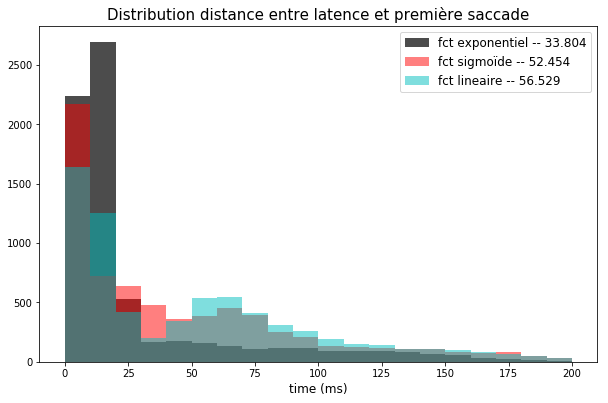

In [6]:
dist_lat_first_sacc()

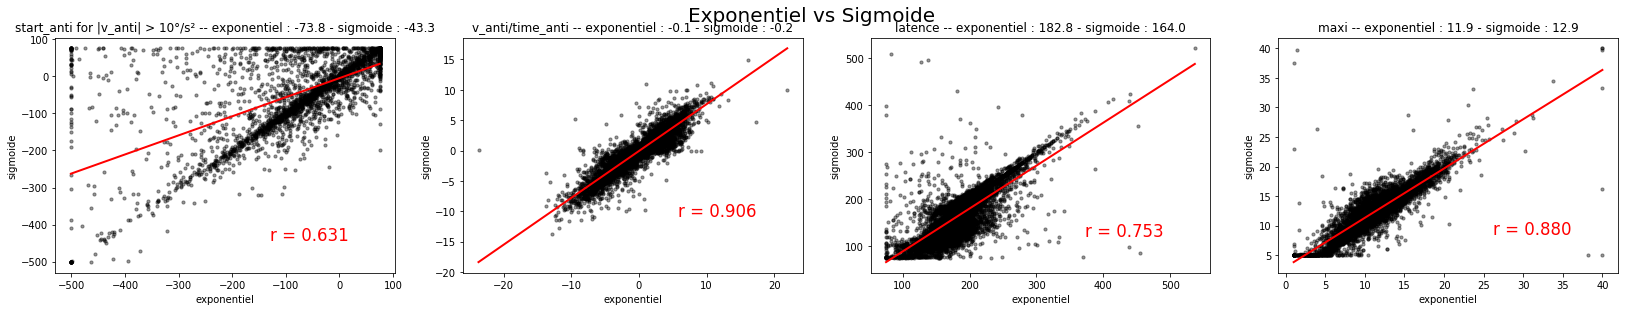

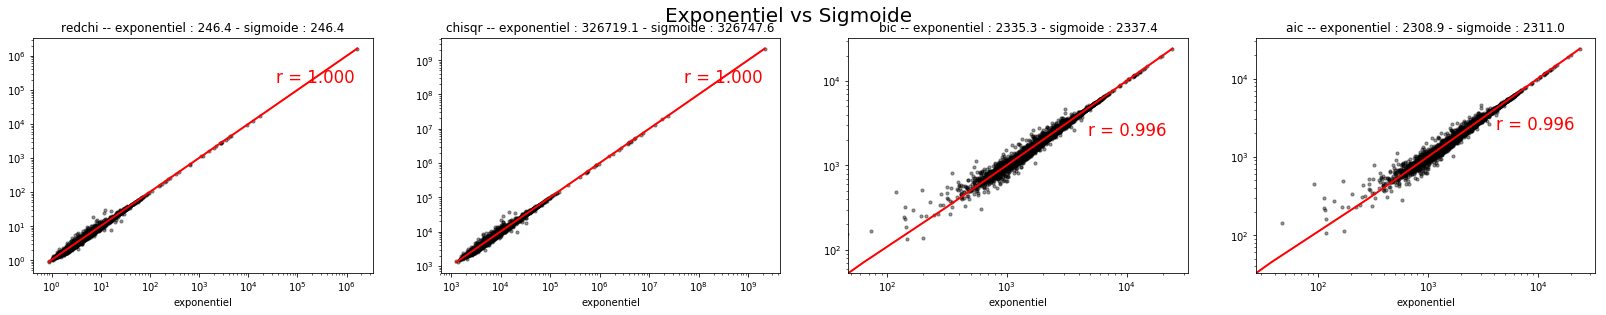

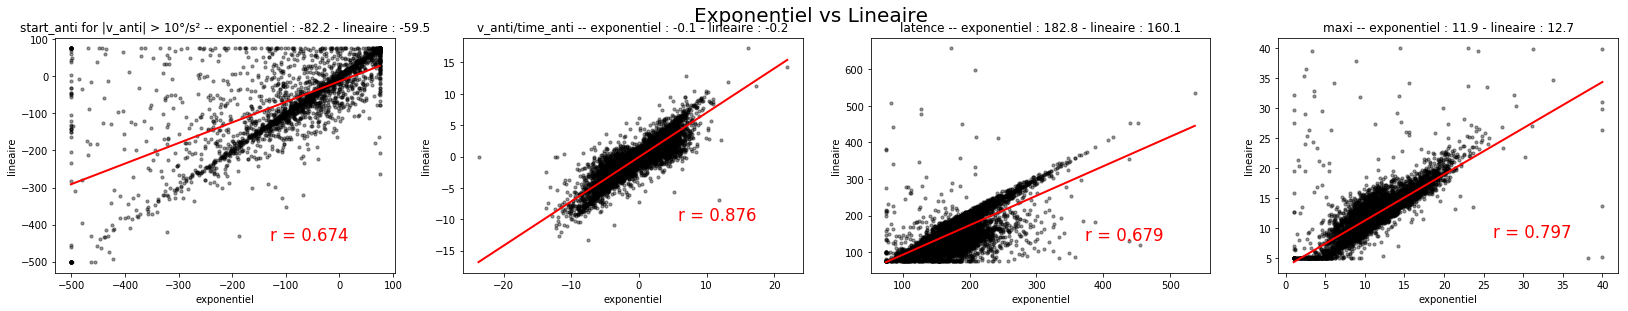

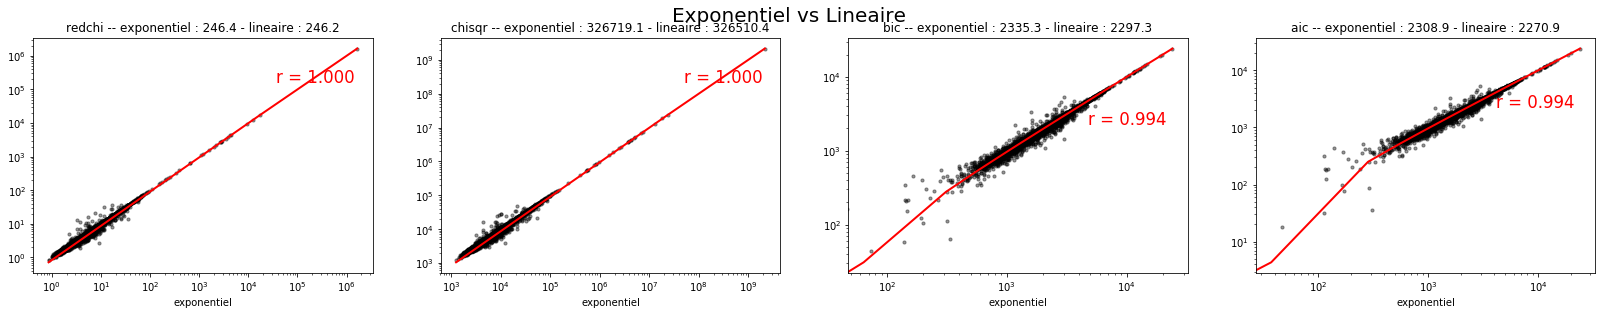

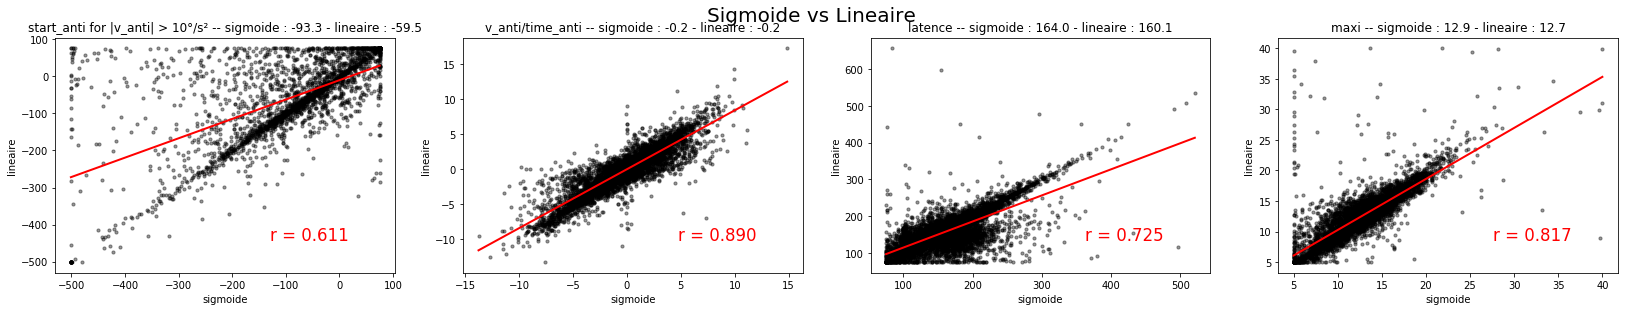

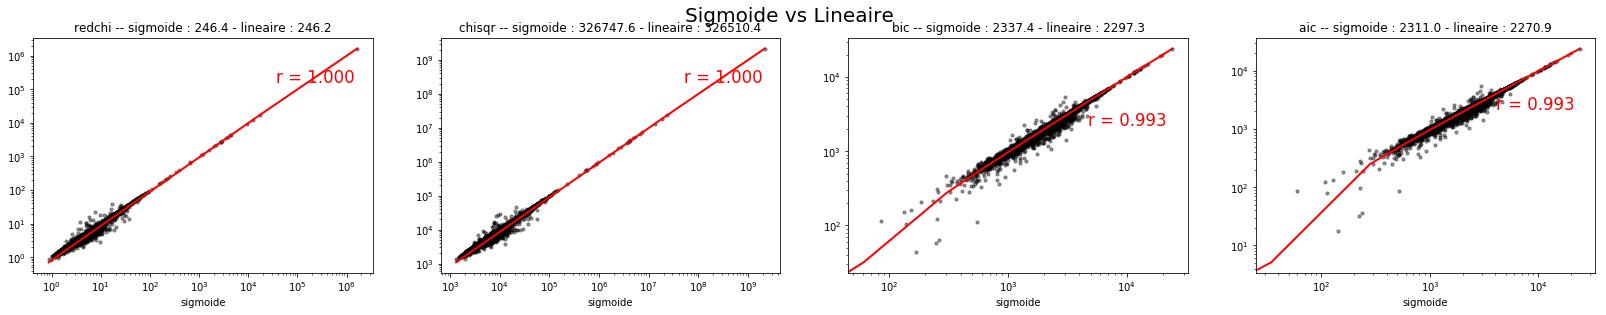

In [7]:
file_old =   'fct_velocity_filt_30'
file_sigmo = 'fct_Vsigmo_filt_30'
file_line =  'fct_Vline_filt_30'

comparaison('Exponentiel vs Sigmoide', file_old, file_sigmo, 'exponentiel', 'sigmoide')
comparaison('Exponentiel vs Lineaire', file_old, file_line, 'exponentiel', 'lineaire')
comparaison('Sigmoide vs Lineaire', file_sigmo, file_line, 'sigmoide', 'lineaire')

In [8]:
def rampe() :
    fig, ax = plt.subplots(1, 3, figsize=(10*3, (10/1.6180)))

    old, sigmo, line = [], [], []
    for s in range(len(sujet)) :
        #with open('parametre/param_Fit_%s_fct_velocity_2_step_False_whitening.pkl'%s, 'rb') as fichier :
        #    param_old = pickle.load(fichier, encoding='latin1')
        with open('parametre/param_Fit_%s_fct_velocity_filt_30.pkl'%sujet[s], 'rb') as fichier :
            param_old = pickle.load(fichier, encoding='latin1')

        with open('parametre/param_Fit_%s_fct_Vsigmo_filt_30.pkl'%sujet[s], 'rb') as fichier :
            param_sigmo = pickle.load(fichier, encoding='latin1')
        with open('parametre/param_Fit_%s_fct_Vline_filt_30.pkl'%sujet[s], 'rb') as fichier :
            param_line = pickle.load(fichier, encoding='latin1')

        #-------------------------------------------------------------------------

        for block in range(3) :                
            old.extend(param_old['tau'][block])
            sigmo.extend(param_sigmo['ramp_pursuit'][block])
            line.extend(param_line['ramp_pursuit'][block])
            

    ax[0].scatter(old, sigmo, c='k', s=10, alpha=0.4)
    ax[0] = regress(ax[0], old, sigmo, t_label=20, color='r')
    ax[0].set_xlabel('tau_expo_fit') ; ax[0].set_ylabel('ramp_pursuit_sigmo_fit')
    ax[0].set_title('Pente Rampe - exponentiel : %0.1f - sigmo : %0.1f'%(np.mean(old), np.mean(sigmo)))
    
    ax[1].scatter(old, line, c='k', s=10, alpha=0.4)
    ax[1] = regress(ax[1], old, line, t_label=20, color='r')
    ax[1].set_xlabel('tau_expo_fit') ; ax[1].set_ylabel('ramp_pursuit_line_fit')
    ax[1].set_title('Pente Rampe - exponentiel : %0.1f - lineaire : %0.1f'%(np.mean(old), np.mean(line)))
    
    ax[2].scatter(sigmo, line, c='k', s=10, alpha=0.4)
    ax[2] = regress(ax[2], sigmo, line, t_label=20, color='r')
    ax[2].set_xlabel('ramp_pursuit_sigmo_fit') ; ax[2].set_ylabel('ramp_pursuit_line_fit')
    ax[2].set_title('Pente Rampe - sigmo : %0.1f - lineaire : %0.1f'%(np.mean(sigmo), np.mean(line)))


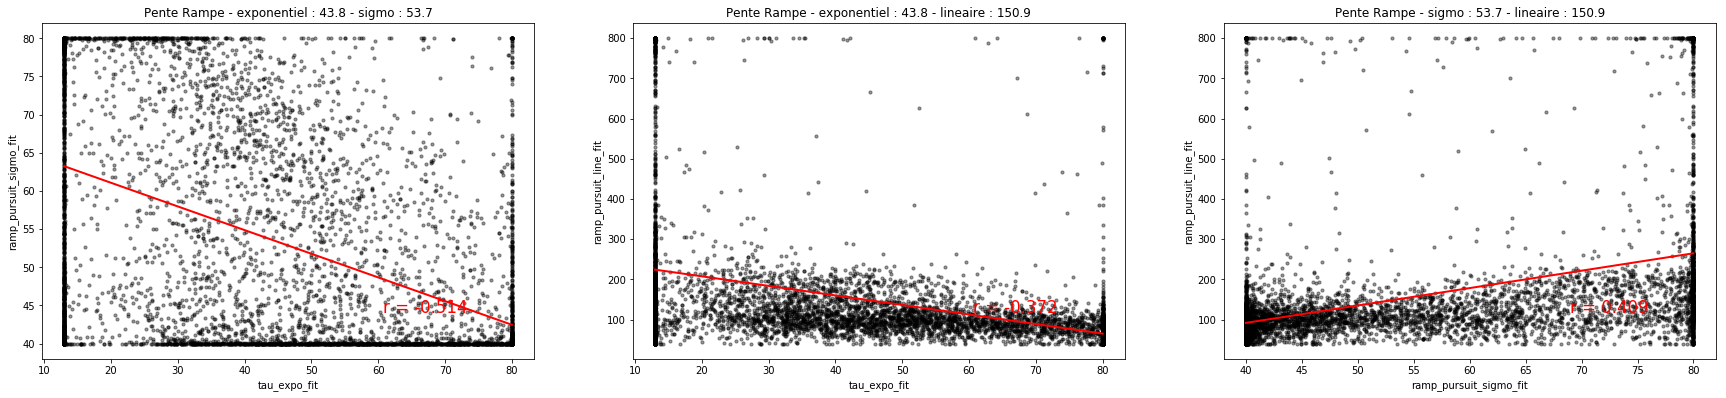

In [9]:
rampe()